In [77]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None 
import datetime as dt
import matplotlib.pyplot as plt
import time
import csv
from pyproj import CRS, Transformer
import os
import rasterio
import geopandas as gpd
from shapely.geometry import Point
from rasterio.mask import mask
from rasterio.merge import merge
from shapely.geometry import box, Point
from pyproj import CRS, Transformer

# The following code is used to preform the economic analysis of speed limit change

In [78]:
#models = pd.read_csv(f"AAA_All_Vehicles_All_Model_160.csv")
print(models.columns)

# Create a list of the initial columns to include in the new DataFrame
initial_columns = [
    'VehicleName', 'VehicleClass', 'StartDate', 'EndDate', 
    'FuelObs', 'TrueTime', 'DistanceTravelled', 'FuelModel', 
    'Num_GPS_IGN_ON'
]

# Create the new DataFrame with selected columns
new_df = models[initial_columns].copy()

# Iterate through the columns in the original DataFrame
for col in models.columns:
    if col.startswith('ModelTime_'):
        # Create a new column: ((ModelTime_ - TrueTime) / DistanceTravelled)
        new_df[f'Change{col}_per_km'] = (models[col] - models['TrueTime']) / models['DistanceTravelled']
    elif col.startswith('FuelModel_'):
        # Create a new column: ((FuelModel_ - FuelModel) / DistanceTravelled)
        new_df[f'Change{col}_per_km'] = (models[col] - models['FuelModel']) / models['DistanceTravelled']
    elif col.startswith(('Fatal', 'Serious', 'Minor', 'Non-injury')):
        # Add the column with 1 subtracted from its values
        new_df[f'Diff{col}'] = models[col] - 1

# Display the new DataFrame
#new_df.to_csv(f"Difference_per_km_All_Vehicles_All_Models_160.csv")
print(new_df)

Index(['VehicleName', 'VehicleClass', 'StartDate', 'EndDate', 'FuelObs',
       'TrueTime', 'DistanceTravelled', 'FuelModel', 'Num_GPS_IGN_ON',
       'FuelModel_80_90_to_100', 'ModelTime_80_90_to_100',
       'Fatal_80_90_to_100', 'Serious_80_90_to_100', 'Minor_80_90_to_100',
       'Non-injury_80_90_to_100', 'FuelModel_90_100_to_80',
       'ModelTime_90_100_to_80', 'Fatal_90_100_to_80', 'Serious_90_100_to_80',
       'Minor_90_100_to_80', 'Non-injury_90_100_to_80',
       'FuelModel_80_100_to_90', 'ModelTime_80_100_to_90',
       'Fatal_80_100_to_90', 'Serious_80_100_to_90', 'Minor_80_100_to_90',
       'Non-injury_80_100_to_90', 'FuelModel_100_to_90', 'ModelTime_100_to_90',
       'Fatal_100_to_90', 'Serious_100_to_90', 'Minor_100_to_90',
       'Non-injury_100_to_90', 'FuelModel_100_to_110', 'ModelTime_100_to_110',
       'Fatal_100_to_110', 'Serious_100_to_110', 'Minor_100_to_110',
       'Non-injury_100_to_110', 'FuelModel_100_to_160', 'ModelTime_100_to_160',
       'Fatal_100_t

In [79]:
#all_vehicles = pd.read_csv(f"Difference_per_km_All_Vehicles_All_Models_160.csv")
print(all_vehicles)

     Unnamed: 0 VehicleName VehicleClass         StartDate           EndDate  \
0             0      DLZ695          SUV   4/08/2020 16:29    6/08/2020 8:17   
1             1      DLZ695          SUV    6/08/2020 8:17   11/08/2020 7:43   
2             2      DLZ695          SUV   11/08/2020 7:43   19/08/2020 7:16   
3             3      DLZ695          SUV   19/08/2020 7:16   20/08/2020 7:25   
4             4      DLZ695          SUV   20/08/2020 7:25  25/08/2020 12:54   
..          ...         ...          ...               ...               ...   
172         172      MHG998        Truck  29/07/2020 16:44    4/08/2020 8:07   
173         173      MHG998        Truck    4/08/2020 8:07  17/08/2020 14:21   
174         174      MHG998        Truck  17/08/2020 14:21    2/09/2020 7:46   
175         175      MHG998        Truck    2/09/2020 7:46   3/09/2020 10:31   
176         176      MHG998        Truck   3/09/2020 10:31   13/09/2020 9:41   

     FuelObs  TrueTime  DistanceTravell

In [80]:
#all_vehicles = pd.read_csv(f"Difference_per_km_All_Vehicles_All_Models_160.csv")
print(all_vehicles.loc[:, 'StartDate'].iloc[-1])
from datetime import datetime
import pandas as pd

# Function to handle multiple datetime formats
def parse_dates(date_series):
    formats = ['%Y-%m-%d %H:%M:%S', '%d/%m/%Y %H:%M']  # List of possible formats
    
    def try_parse(date):
        for fmt in formats:
            try:
                return datetime.strptime(date, fmt)
            except ValueError:
                continue
        raise ValueError(f"Unknown date format: {date}")

    return date_series.apply(try_parse)

# Apply the function to 'StartDate' and 'EndDate' columns
all_vehicles['StartDate'] = parse_dates(all_vehicles['StartDate'])
all_vehicles['EndDate'] = parse_dates(all_vehicles['EndDate'])


all_vehicles['StartDate'] = pd.to_datetime(all_vehicles['StartDate'])
all_vehicles['EndDate'] = pd.to_datetime(all_vehicles['EndDate'])
all_vehicles['TrueTime'] = (all_vehicles['EndDate']-all_vehicles['StartDate']).dt.total_seconds()
all_vehicles['Days'] = all_vehicles['TrueTime']/86400
print(all_vehicles)

3/09/2020 10:31
     Unnamed: 0 VehicleName VehicleClass           StartDate  \
0             0      DLZ695          SUV 2020-08-04 16:29:00   
1             1      DLZ695          SUV 2020-08-06 08:17:00   
2             2      DLZ695          SUV 2020-08-11 07:43:00   
3             3      DLZ695          SUV 2020-08-19 07:16:00   
4             4      DLZ695          SUV 2020-08-20 07:25:00   
..          ...         ...          ...                 ...   
172         172      MHG998        Truck 2020-07-29 16:44:00   
173         173      MHG998        Truck 2020-08-04 08:07:00   
174         174      MHG998        Truck 2020-08-17 14:21:00   
175         175      MHG998        Truck 2020-09-02 07:46:00   
176         176      MHG998        Truck 2020-09-03 10:31:00   

                EndDate  FuelObs   TrueTime  DistanceTravelled   FuelModel  \
0   2020-08-06 08:17:00    51.15   143280.0          221.66842   22.680838   
1   2020-08-11 07:43:00    43.04   429960.0          156.66

In [227]:
# Cost of Diesel in Blenhiem in 2020 using $2.189 per liter atm (this is current prices) 
# GPS data ranges from 1/5/2020 - 15/9/2020
Diesel_cost = 2.189

# Cost of Time Savings
payrate_per_hour = 100 #150???
payrate_per_seconds = payrate_per_hour / (60*60)

# Fatal, Serious, Minor, Non-injury number of crashes in 2020 and probability per day
num_crashes = [304, 2080,8483, 86939]
num_vehicles = 4712629
num_days_2020 = 365
cost_crashes = [16095200,890500,105400,3800]
prob_crashes_per_day = [x/(num_vehicles * num_days_2020) for x in num_crashes]
cost_crashes_per_day = [x*y for x,y in zip(cost_crashes, prob_crashes_per_day)]
print(prob_crashes_per_day)
print(cost_crashes_per_day)

[1.7673292600133963e-07, 1.2092252831670607e-06, 4.931662537070276e-06, 5.054271004483706e-05]
[2.8445517905767614, 1.0768151146602676, 0.5197972314072071, 0.1920622981703808]


In [229]:
print(all_vehicles.columns)
print(all_vehicles.dtypes)
print(all_vehicles)

Index(['Unnamed: 0', 'VehicleName', 'VehicleClass', 'StartDate', 'EndDate',
       'FuelObs', 'TrueTime', 'DistanceTravelled', 'FuelModel',
       'Num_GPS_IGN_ON', 'ChangeFuelModel_80_90_to_100_per_km',
       'ChangeModelTime_80_90_to_100_per_km', 'DiffFatal_80_90_to_100',
       'DiffSerious_80_90_to_100', 'DiffMinor_80_90_to_100',
       'DiffNon-injury_80_90_to_100', 'ChangeFuelModel_90_100_to_80_per_km',
       'ChangeModelTime_90_100_to_80_per_km', 'DiffFatal_90_100_to_80',
       'DiffSerious_90_100_to_80', 'DiffMinor_90_100_to_80',
       'DiffNon-injury_90_100_to_80', 'ChangeFuelModel_80_100_to_90_per_km',
       'ChangeModelTime_80_100_to_90_per_km', 'DiffFatal_80_100_to_90',
       'DiffSerious_80_100_to_90', 'DiffMinor_80_100_to_90',
       'DiffNon-injury_80_100_to_90', 'ChangeFuelModel_100_to_90_per_km',
       'ChangeModelTime_100_to_90_per_km', 'DiffFatal_100_to_90',
       'DiffSerious_100_to_90', 'DiffMinor_100_to_90',
       'DiffNon-injury_100_to_90', 'ChangeFuelMo

In [231]:
df = all_vehicles
all_vehicles_cost_change = df[df.columns[~df.columns.str.startswith(("ChangeTime", "ChangeFuelModel")) |df.columns.str.endswith("_per_km")]].copy()

#Diesel_cost = 1.5
#cost_crashes_per_day = [0.2, 0.3, 0.4, 0.5]  # Example list

# Multiply columns starting with ChangeFuelModel by Diesel_cost
fuel_columns = all_vehicles_cost_change.columns[all_vehicles_cost_change.columns.str.startswith("ChangeFuelModel")]
all_vehicles_cost_change[fuel_columns] *= Diesel_cost

# Multiply columns starting with ChangeTime by payrate_per_seconds
time_columns = all_vehicles_cost_change.columns[all_vehicles_cost_change.columns.str.startswith("ChangeModelTime")]
all_vehicles_cost_change[time_columns] *=  payrate_per_seconds

# Multiply Diff* columns by Days and respective cost_crashes_per_day index
diff_prefixes = ("DiffFatal", "DiffSerious", "DiffMinor", "DiffNon-injury")
for i, prefix in enumerate(diff_prefixes):
    diff_columns = all_vehicles_cost_change.columns[all_vehicles_cost_change.columns.str.startswith(prefix)]
    print(all_vehicles_cost_change[diff_columns].columns)
    
    all_vehicles_cost_change[diff_columns] = all_vehicles_cost_change[diff_columns].mul(cost_crashes_per_day[i], axis=0)
    #all_vehicles_cost_change["Days"] * do not multiply by the value of days to have diff in terms of cost per day
    print(cost_crashes_per_day[i])
    print(prefix)
    print(all_vehicles_cost_change[diff_columns])

# Rename columns that were modified to include Cost_* at the start
modified_columns = list(fuel_columns) + list(time_columns)+ [
    col for prefix in diff_prefixes for col in all_vehicles_cost_change.columns if col.startswith(prefix)
]
all_vehicles_cost_change.rename(
    columns={col: f"Cost_{col}" for col in modified_columns},
    inplace=True,
)

Economic_costs = all_vehicles_cost_change

#all_vehicles_cost_change.to_csv(f"Cost_per_km_All_Vehicles_All_Models_160.csv")

Index(['DiffFatal_80_90_to_100', 'DiffFatal_90_100_to_80',
       'DiffFatal_80_100_to_90', 'DiffFatal_100_to_90', 'DiffFatal_100_to_110',
       'DiffFatal_100_to_160'],
      dtype='object')
2.8445517905767614
DiffFatal
     DiffFatal_80_90_to_100  DiffFatal_90_100_to_80  DiffFatal_80_100_to_90  \
0                  0.781494               -0.509884               -0.075534   
1                  0.522261               -0.216421                0.023266   
2                  0.380210               -0.278829               -0.061007   
3                  1.219893               -0.238626                0.243386   
4                  0.000666               -0.186726               -0.117057   
..                      ...                     ...                     ...   
172                3.460851               -0.333306                0.341537   
173                0.627515               -0.326594                0.016591   
174                0.621948               -0.202267                

In [233]:
print(Economic_costs.columns)
print(Economic_costs.dtypes)
print(Economic_costs)

Index(['Unnamed: 0', 'VehicleName', 'VehicleClass', 'StartDate', 'EndDate',
       'FuelObs', 'TrueTime', 'DistanceTravelled', 'FuelModel',
       'Num_GPS_IGN_ON', 'Cost_ChangeFuelModel_80_90_to_100_per_km',
       'Cost_ChangeModelTime_80_90_to_100_per_km',
       'Cost_DiffFatal_80_90_to_100', 'Cost_DiffSerious_80_90_to_100',
       'Cost_DiffMinor_80_90_to_100', 'Cost_DiffNon-injury_80_90_to_100',
       'Cost_ChangeFuelModel_90_100_to_80_per_km',
       'Cost_ChangeModelTime_90_100_to_80_per_km',
       'Cost_DiffFatal_90_100_to_80', 'Cost_DiffSerious_90_100_to_80',
       'Cost_DiffMinor_90_100_to_80', 'Cost_DiffNon-injury_90_100_to_80',
       'Cost_ChangeFuelModel_80_100_to_90_per_km',
       'Cost_ChangeModelTime_80_100_to_90_per_km',
       'Cost_DiffFatal_80_100_to_90', 'Cost_DiffSerious_80_100_to_90',
       'Cost_DiffMinor_80_100_to_90', 'Cost_DiffNon-injury_80_100_to_90',
       'Cost_ChangeFuelModel_100_to_90_per_km',
       'Cost_ChangeModelTime_100_to_90_per_km', 'Cost

In [235]:
# Select all columns that start with 'Cost_'
cost_columns = Economic_costs.columns[Economic_costs.columns.str.startswith('Cost_')]

# Multiply the values in the 'Cost_' columns by the 'Days' column in the same row
Economic_costs[cost_columns] = Economic_costs[cost_columns].mul(Economic_costs["DistanceTravelled"], axis=0)

Economic_costs.columns = Economic_costs.columns.str.replace('_per_km$', '', regex=True)

Eccony = Economic_costs.copy()
print(Eccony)

#Eccony.to_csv(f"Cost_per_FuelUp_All_Vehicles_All_Models_160.csv")

     Unnamed: 0 VehicleName VehicleClass           StartDate  \
0             0      DLZ695          SUV 2020-08-04 16:29:00   
1             1      DLZ695          SUV 2020-08-06 08:17:00   
2             2      DLZ695          SUV 2020-08-11 07:43:00   
3             3      DLZ695          SUV 2020-08-19 07:16:00   
4             4      DLZ695          SUV 2020-08-20 07:25:00   
..          ...         ...          ...                 ...   
172         172      MHG998        Truck 2020-07-29 16:44:00   
173         173      MHG998        Truck 2020-08-04 08:07:00   
174         174      MHG998        Truck 2020-08-17 14:21:00   
175         175      MHG998        Truck 2020-09-02 07:46:00   
176         176      MHG998        Truck 2020-09-03 10:31:00   

                EndDate  FuelObs   TrueTime  DistanceTravelled   FuelModel  \
0   2020-08-06 08:17:00    51.15   143280.0          221.66842   22.680838   
1   2020-08-11 07:43:00    43.04   429960.0          156.66714   18.517268 

In [238]:
#almost2 = pd.read_csv(f"Cost_per_km_All_Vehicles_All_Models_160.csv")
print(almost2.columns)
almost = almost2.copy()
print(almost)

Index(['Unnamed: 0.1', 'Unnamed: 0', 'VehicleName', 'VehicleClass',
       'StartDate', 'EndDate', 'FuelObs', 'TrueTime', 'DistanceTravelled',
       'FuelModel', 'Num_GPS_IGN_ON',
       'Cost_ChangeFuelModel_80_90_to_100_per_km',
       'Cost_ChangeModelTime_80_90_to_100_per_km',
       'Cost_DiffFatal_80_90_to_100', 'Cost_DiffSerious_80_90_to_100',
       'Cost_DiffMinor_80_90_to_100', 'Cost_DiffNon-injury_80_90_to_100',
       'Cost_ChangeFuelModel_90_100_to_80_per_km',
       'Cost_ChangeModelTime_90_100_to_80_per_km',
       'Cost_DiffFatal_90_100_to_80', 'Cost_DiffSerious_90_100_to_80',
       'Cost_DiffMinor_90_100_to_80', 'Cost_DiffNon-injury_90_100_to_80',
       'Cost_ChangeFuelModel_80_100_to_90_per_km',
       'Cost_ChangeModelTime_80_100_to_90_per_km',
       'Cost_DiffFatal_80_100_to_90', 'Cost_DiffSerious_80_100_to_90',
       'Cost_DiffMinor_80_100_to_90', 'Cost_DiffNon-injury_80_100_to_90',
       'Cost_ChangeFuelModel_100_to_90_per_km',
       'Cost_ChangeModelTime_1

In [240]:
# Define the columns to exclude
exclude_columns = ['VehicleName', 'VehicleClass', 'StartDate', 'EndDate']

# Select columns for aggregation (all columns except the ones to exclude)
columns_for_aggregation = [col for col in almost.columns if col not in exclude_columns]

# First, group by VehicleName and calculate mean and std for other columns
vehicle_name_stats = almost.groupby('VehicleName')[columns_for_aggregation].agg(['mean', 'std']).reset_index()

# Add an 'Identifier' column for VehicleName
vehicle_name_stats['Identifier'] = vehicle_name_stats['VehicleName']
vehicle_name_stats = vehicle_name_stats.drop(columns=['VehicleName'])

# Now, group by VehicleClass and calculate mean and std for other columns
vehicle_class_stats = almost.groupby('VehicleClass')[columns_for_aggregation].agg(['mean', 'std']).reset_index()

# Add an 'Identifier' column for VehicleClass
vehicle_class_stats['Identifier'] = vehicle_class_stats['VehicleClass']
vehicle_class_stats = vehicle_class_stats.drop(columns=['VehicleClass'])

# Flatten the multi-level columns after aggregation
vehicle_name_stats.columns = ['_'.join(col).strip() for col in vehicle_name_stats.columns.values]
vehicle_class_stats.columns = ['_'.join(col).strip() for col in vehicle_class_stats.columns.values]

# Concatenate the two dataframes (VehicleName and VehicleClass)
final_result = pd.concat([vehicle_name_stats, vehicle_class_stats], ignore_index=True)
final_result.set_index('Identifier_', inplace=True)

# Transpose the DataFrame
transposed_result = final_result.transpose()
transposed_result.reset_index()
# Save the result to a CSV with an 'Identifier' column
#transposed_result.to_csv('Vehicle_stats_all_6_scenarios_per_km_160.csv')#, index=False)

# Print the first few rows of the final result to verify
print(transposed_result)

Identifier_                             DLZ695     HLW912     HQW812  \
Unnamed: 0.1_mean                     4.000000  21.500000  40.000000   
Unnamed: 0.1_std                      2.738613   7.648529   3.316625   
Unnamed: 0_mean                       4.000000  21.500000  40.000000   
Unnamed: 0_std                        2.738613   7.648529   3.316625   
FuelObs_mean                         44.214444  58.945385  59.372727   
...                                        ...        ...        ...   
Cost_DiffMinor_100_to_160_std         0.207131   0.128038   0.208183   
Cost_DiffNon-injury_100_to_160_mean   0.038503   0.040443   0.027096   
Cost_DiffNon-injury_100_to_160_std    0.019588   0.011246   0.019206   
Days_mean                            10.744367   5.198531  11.120391   
Days_std                             18.665099   2.322369   4.539564   

Identifier_                             JRK947     JSJ858     JZD724  \
Unnamed: 0.1_mean                    51.000000  64.000000  78.5

C:\Users\csu55\AppData\Local\Temp\ipykernel_10824\2679487708.py:12: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  vehicle_name_stats = vehicle_name_stats.drop(columns=['VehicleName'])
C:\Users\csu55\AppData\Local\Temp\ipykernel_10824\2679487708.py:19: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  vehicle_class_stats = vehicle_class_stats.drop(columns=['VehicleClass'])


In [276]:
#costs = pd.read_csv(f"Vehicle_stats_all_6_scenarios_per_km_160.csv")
# Replace the specified scenario name
costs['Unnamed: 0'] = costs['Unnamed: 0'].str.replace('80_100_to_90', '100_80_to_90', regex=False)

# Define scenario names
scenario_names = ['80_90_to_100', '90_100_to_80', '100_80_to_90', '100_to_90', '100_to_110', '100_to_160']

# Extract 'Days_mean' and 'DistanceTravelled_mean' for later use
days_mean = costs[costs['Unnamed: 0'] == 'Days_mean']
distance_travelled = costs[costs['Unnamed: 0'] == 'DistanceTravelled_mean']

# Define crash types that we want to filter on (Fatal, Serious, Minor, Non-injury)
crash_types = ['Fatal', 'Serious', 'Minor', 'Non-injury']

# List to store new rows to append
new_rows = []

# Iterate through each scenario and process the data
for scenario in scenario_names:
    # Filter the rows for the current scenario
    almost2 = costs[costs['Unnamed: 0'].str.contains(scenario, na=False)]
    
    # Filter the rows where 'Unnamed: 0' contains any of the crash types and ends with '_mean'
    crash_rows = almost2[almost2['Unnamed: 0'].str.contains(r'(?:' + '|'.join(crash_types) + r').*_mean$', na=False, regex=True)]
    
    # Sum the relevant columns for these crash types
    crash_sum = crash_rows.drop(columns=['Unnamed: 0']).sum()  # Sum all columns except 'Unnamed: 0'
    
    # Get the 'Days_mean' and 'DistanceTravelled_mean' for the current scenario
    days_value = days_mean.drop(columns=['Unnamed: 0']).iloc[0]  # Assuming one row for Days_mean
    distance_value = distance_travelled.drop(columns=['Unnamed: 0']).iloc[0]  # Assuming one row for DistanceTravelled_mean
    
    # Perform the calculation: (Crash sum * Days_mean) / DistanceTravelled_mean
    crashes_per_km_mean = (crash_sum * days_value) / distance_value
    
    # Name the result for clarity
    crashes_per_km_mean.name = f'Crashes_{scenario}_per_km_mean'
    
    # Add a row for the current scenario's results
    crashes_per_km_mean_row = pd.DataFrame(crashes_per_km_mean).T  # Convert Series to DataFrame and transpose it
    
    # Set the 'Unnamed: 0' column to the corresponding name
    crashes_per_km_mean_row['Unnamed: 0'] = f'Crashes_{scenario}_per_km_mean'
    
    # Append this new row to the list of new rows
    new_rows.append(crashes_per_km_mean_row)
    
    # ** New step: Sum 'Fuel', 'Crashes', and 'Time' rows to create 'Total_{scenario}_per_km_mean' **
    fuel_rows = almost2[almost2['Unnamed: 0'].str.contains('Fuel.*_mean', na=False)]
    crashes_rows = almost2[almost2['Unnamed: 0'].str.contains('Crashes.*_mean', na=False)]
    time_rows = almost2[almost2['Unnamed: 0'].str.contains('Time.*_mean', na=False)]
    
    # Sum the values for Fuel, Crashes, and Time rows
    total_sum = fuel_rows.drop(columns=['Unnamed: 0']).sum() + crashes_rows.drop(columns=['Unnamed: 0']).sum() + time_rows.drop(columns=['Unnamed: 0']).sum()
    
    # Perform the calculation: (Total sum * Days_mean) / DistanceTravelled_mean
    total_per_km_mean = (total_sum * days_value) / distance_value
    
    # Name the result for clarity
    total_per_km_mean.name = f'Total_{scenario}_per_km_mean'
    
    # Add a row for the current scenario's total results
    total_per_km_mean_row = pd.DataFrame(total_per_km_mean).T  # Convert Series to DataFrame and transpose it
    
    # Set the 'Unnamed: 0' column to the corresponding name
    total_per_km_mean_row['Unnamed: 0'] = f'Total_{scenario}_per_km_mean'
    
    # Append this new row to the list of new rows
    new_rows.append(total_per_km_mean_row)

# Concatenate the new rows with the original costs dataframe
costs = pd.concat([costs] + new_rows, ignore_index=True)

# Print the modified costs DataFrame
print(costs)
#costs.to_csv(f"Vehicle_stats_all_6_scenarios_per_km_160.csv")


                        Unnamed: 0     DLZ695     HLW912     HQW812  \
0                Unnamed: 0.1_mean   4.000000  21.500000  40.000000   
1                 Unnamed: 0.1_std   2.738613   7.648529   3.316625   
2                  Unnamed: 0_mean   4.000000  21.500000  40.000000   
3                   Unnamed: 0_std   2.738613   7.648529   3.316625   
4                     FuelObs_mean  44.214444  58.945385  59.372727   
..                             ...        ...        ...        ...   
95     Total_100_to_90_per_km_mean   0.001885   0.000892   0.000635   
96  Crashes_100_to_110_per_km_mean   0.013233   0.004867   0.006039   
97    Total_100_to_110_per_km_mean  -0.001505  -0.000695  -0.000504   
98  Crashes_100_to_160_per_km_mean   0.716945   0.304688   0.337785   
99    Total_100_to_160_per_km_mean  -0.005283  -0.002250  -0.001686   

       JRK947     JSJ858     JZD724     KMR237     KSU878      LDG161  \
0   51.000000  64.000000  78.500000  86.000000  93.500000  109.000000   
1

                            Unnamed: 0    DLZ695    HLW912    HQW812  \
14  FuelModel_80_90_to_100_per_km_mean  0.000852  0.000363  0.004080   
16       Time_80_90_to_100_per_km_mean -0.032541 -0.024849 -0.078618   
88    Crashes_80_90_to_100_per_km_mean  0.015156  0.002097  0.023927   
89      Total_80_90_to_100_per_km_mean -0.000990 -0.000271 -0.001507   

      JRK947    JSJ858    JZD724    KMR237    KSU878    LDG161    LWY799  \
14  0.001314  0.000752  0.000031 -0.000341  0.000425  0.000350 -0.000091   
16 -0.049242 -0.034698 -0.047833 -0.038010 -0.043274 -0.025888 -0.042215   
88  0.015368  0.007695  0.009088  0.006650  0.004664  0.005473  0.004743   
89 -0.001248 -0.000518 -0.000965 -0.000875 -0.000599 -0.000328 -0.000722   

      MCF324     MGC95    MHG998       Car       SUV     Truck  
14  0.004950  0.001046 -0.001656  0.000539  0.001278 -0.001656  
16 -0.048125 -0.027022 -0.063145 -0.030017 -0.040962 -0.063145  
88  0.009583  0.005943  0.059761  0.006444  0.007859  0.059761 

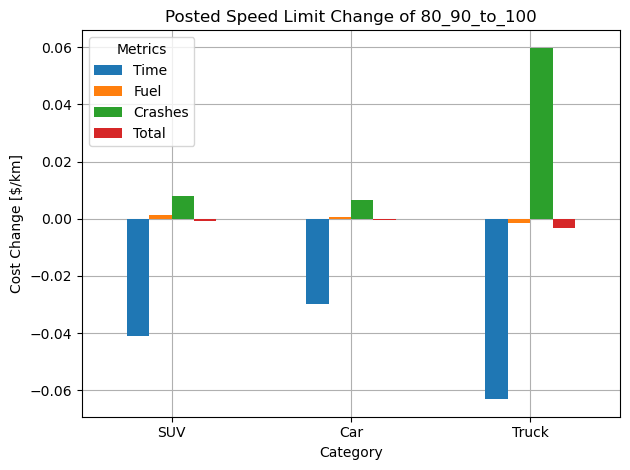

                            Unnamed: 0    DLZ695    HLW912    HQW812  \
26  FuelModel_90_100_to_80_per_km_mean  0.004566  0.006322  0.000790   
28       Time_90_100_to_80_per_km_mean  0.135456  0.177529  0.070191   
90    Crashes_90_100_to_80_per_km_mean -0.012389 -0.004061 -0.005346   
91      Total_90_100_to_80_per_km_mean  0.004374  0.002036  0.001435   

      JRK947    JSJ858    JZD724    KMR237    KSU878    LDG161    LWY799  \
26  0.001632 -0.000613  0.002647  0.000040  0.004077 -0.001910  0.002145   
28  0.112542  0.067042  0.124220  0.031489  0.127312  0.101613  0.117265   
90 -0.008818 -0.003707 -0.006344 -0.002310 -0.003597 -0.006521 -0.003615   
91  0.002972  0.001013  0.002562  0.000720  0.001837  0.001281  0.002038   

      MCF324     MGC95    MHG998       Car       SUV     Truck  
26 -0.003334 -0.001941  0.013735 -0.001302  0.002014  0.013735  
28  0.073127  0.065637  0.123487  0.085408  0.114857  0.123487  
90 -0.003495 -0.003724 -0.024368 -0.005341 -0.004938 -0.024368 

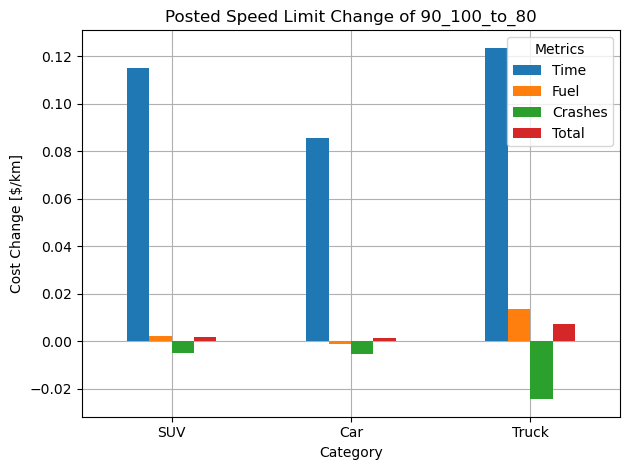

                            Unnamed: 0    DLZ695    HLW912    HQW812  \
38  FuelModel_100_80_to_90_per_km_mean  0.000820  0.000713  0.000339   
40       Time_100_80_to_90_per_km_mean  0.043601  0.066060 -0.010610   
92    Crashes_100_80_to_90_per_km_mean -0.002717 -0.001905  0.004628   
93      Total_100_80_to_90_per_km_mean  0.001388  0.000740 -0.000208   

      JRK947    JSJ858    JZD724    KMR237    KSU878    LDG161    LWY799  \
38 -0.000716 -0.000326 -0.000867 -0.000911  0.000067 -0.001251 -0.001114   
40  0.024202  0.011736  0.030298 -0.005809  0.033932  0.032779  0.029877   
92 -0.000354  0.000303 -0.000845  0.001042 -0.000710 -0.002162 -0.000706   
93  0.000611  0.000174  0.000594 -0.000153  0.000475  0.000405  0.000491   

      MCF324     MGC95    MHG998       Car       SUV     Truck  
38 -0.001197 -0.001830  0.002004 -0.000817 -0.000453  0.002004  
40  0.007226  0.015218  0.022236  0.022915  0.029623  0.022236  
92  0.000850 -0.000383  0.001565 -0.001116 -0.000510  0.001565 

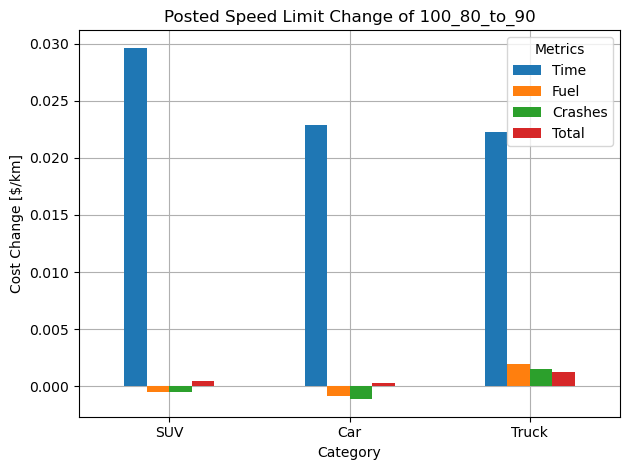

                         Unnamed: 0    DLZ695    HLW912    HQW812    JRK947  \
50  FuelModel_100_to_90_per_km_mean  0.000931  0.000893 -0.000503 -0.000512   
52       Time_100_to_90_per_km_mean  0.059414  0.079627  0.031924  0.047647   
94    Crashes_100_to_90_per_km_mean -0.007312 -0.002609 -0.003374 -0.004988   
95      Total_100_to_90_per_km_mean  0.001885  0.000892  0.000635  0.001227   

      JSJ858    JZD724    KMR237    KSU878    LDG161    LWY799    MCF324  \
50 -0.000509 -0.000283 -0.000339  0.000451 -0.001317 -0.000481 -0.002815   
52  0.028913  0.056182  0.014551  0.057424  0.046628  0.052381  0.033233   
94 -0.002110 -0.004043 -0.001418 -0.002294 -0.004031 -0.002284 -0.002226   
95  0.000433  0.001129  0.000324  0.000809  0.000582  0.000886  0.000385   

       MGC95    MHG998       Car       SUV     Truck  
50 -0.001901  0.004362 -0.000939 -0.000468  0.004362  
52  0.029168  0.050662  0.038324  0.051303  0.050662  
94 -0.002280 -0.012301 -0.003224 -0.003081 -0.012301  
95 

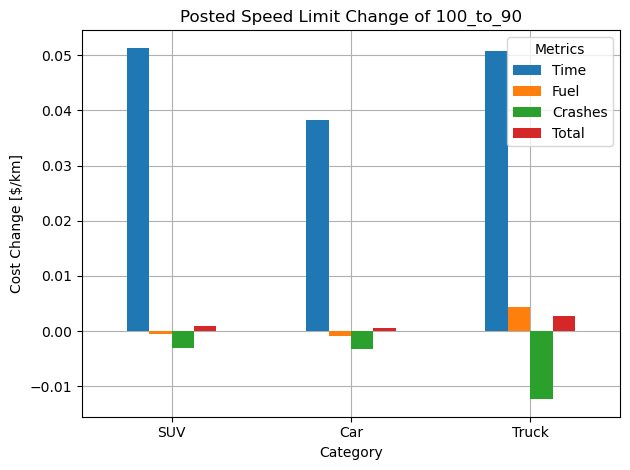

                          Unnamed: 0    DLZ695    HLW912    HQW812    JRK947  \
62  FuelModel_100_to_110_per_km_mean  0.001727  0.003342  0.002195  0.003164   
64       Time_100_to_110_per_km_mean -0.049913 -0.066123 -0.027143 -0.039976   
96    Crashes_100_to_110_per_km_mean  0.013233  0.004867  0.006039  0.009217   
97      Total_100_to_110_per_km_mean -0.001505 -0.000695 -0.000504 -0.000958   

      JSJ858    JZD724    KMR237    KSU878    LDG161    LWY799    MCF324  \
62  0.000945  0.003299  0.001021  0.002520  0.001999  0.003403  0.004982   
64 -0.024597 -0.047272 -0.012689 -0.048187 -0.040456 -0.043899 -0.028290   
96  0.003711  0.007376  0.002440  0.004214  0.006985  0.004311  0.004157   
97 -0.000361 -0.000888 -0.000266 -0.000638 -0.000494 -0.000691 -0.000295   

       MGC95    MHG998       Car       SUV     Truck  
62  0.003704 -0.000258  0.001505  0.003262 -0.000258  
64 -0.024829 -0.043205 -0.033022 -0.043053 -0.043205  
96  0.004271  0.020528  0.005610  0.005695  0.020528 

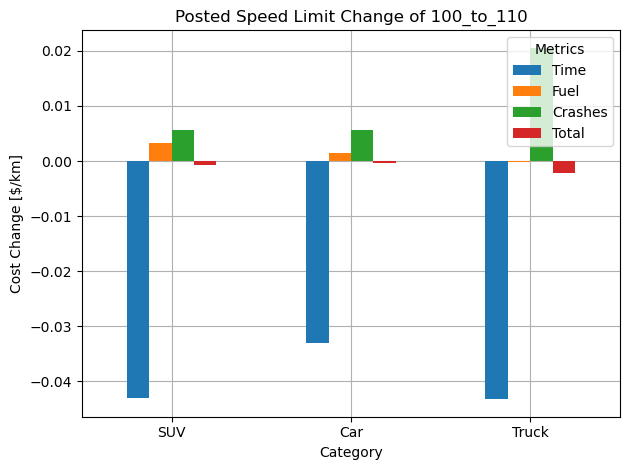

                          Unnamed: 0    DLZ695    HLW912    HQW812    JRK947  \
74  FuelModel_100_to_160_per_km_mean  0.046064  0.076685  0.036082  0.054707   
76       Time_100_to_160_per_km_mean -0.215196 -0.279789 -0.119478 -0.171941   
98    Crashes_100_to_160_per_km_mean  0.716945  0.304688  0.337785  0.559554   
99      Total_100_to_160_per_km_mean -0.005283 -0.002250 -0.001686 -0.003052   

      JSJ858    JZD724    KMR237    KSU878    LDG161    LWY799    MCF324  \
74  0.011277  0.060441  0.015438  0.055008  0.020903  0.059740  0.059443   
76 -0.108120 -0.204361 -0.058478 -0.207486 -0.184194 -0.188705 -0.124880   
98  0.188753  0.426166  0.441009  0.251776  0.987757  0.292023  0.334969   
99 -0.001477 -0.002906 -0.000982 -0.002132 -0.002098 -0.002201 -0.000827   

       MGC95    MHG998       Car       SUV     Truck  
74  0.046764  0.050585  0.016391  0.057186  0.050585  
76 -0.109565 -0.190395 -0.148534 -0.185432 -0.190395  
98  0.351533  0.775947  0.649568  0.370895  0.775947 

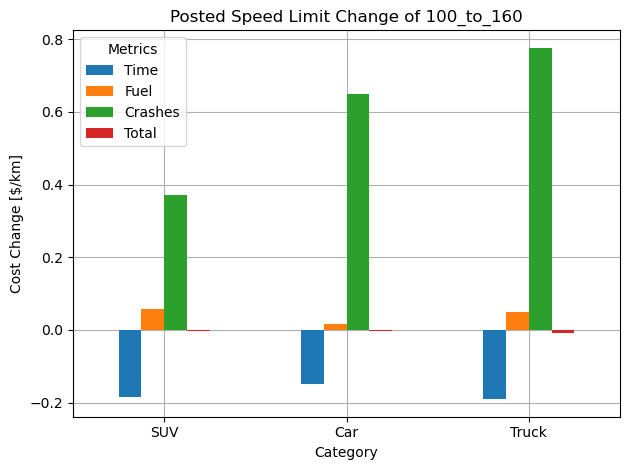

In [268]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming your dataframe is named 'costs'
scenario_names = ['80_90_to_100', '90_100_to_80', '100_80_to_90', '100_to_90', '100_to_110', '100_to_160']

# Loop through each scenario name and create a new dataframe for each
for scenario in scenario_names:
    # Filter rows where the scenario name is in the 'Unnamed: 0' column
    scenario_df = costs[costs['Unnamed: 0'].str.contains(scenario, na=False)]
    #print(scenario_df)
    # Select rows where 'Unnamed: 0' starts with 'Time', 'Fuel', or 'Crashes' and ends with '_mean'
    filtered_df = scenario_df[scenario_df['Unnamed: 0'].str.startswith(('Time', 'Fuel', 'Crashes', 'Total')) & scenario_df['Unnamed: 0'].str.endswith('_mean')]
    print(filtered_df)
    # Extract the relevant columns for plotting
    plot_df = filtered_df[['Unnamed: 0', 'SUV', 'Car', 'Truck']]#.set_index('Unnamed: 0')


    order = ['Time','Fuel', 'Crashes', 'Total']

    # Create a sorting key based on the desired order
    plot_df['sort_key'] = plot_df['Unnamed: 0'].apply(lambda x: next((i for i, word in enumerate(order) if x.startswith(word)), float('inf')))
    
    # Sort the DataFrame by the sorting key and drop the key afterward
    plot_df = plot_df.sort_values('sort_key').drop(columns='sort_key').reset_index(drop=True)
    plot_df = plot_df.set_index('Unnamed: 0')

        # Create a bar chart for each scenario
    plot_df.T.plot(kind='bar', width=0.5, zorder=2)

    # Set the title and labels
    plt.title(f'Posted Speed Limit Change of {scenario}')
    plt.xlabel('Category')
    plt.ylabel('Cost Change [$/km]')
    plt.xticks(rotation=0)
    plt.grid(True, zorder=1)

    # Set the x-axis labels to be the category names: SUV, Car, Truck
    plt.xticks(range(3), ['SUV', 'Car', 'Truck'])
    plt.legend(['Time','Fuel', 'Crashes', 'Total'], title='Metrics')

    # Show the plot
    plt.tight_layout()  # Adjust layout to avoid clipping

    # Optionally save the plot if needed
    #plt.savefig(f"{scenario}_category_comparison.png")
    plt.show()

                            Unnamed: 0    DLZ695    HLW912    HQW812  \
14  FuelModel_80_90_to_100_per_km_mean  0.000852  0.000363  0.004080   
16       Time_80_90_to_100_per_km_mean -0.032541 -0.024849 -0.078618   
88    Crashes_80_90_to_100_per_km_mean  0.015156  0.002097  0.023927   
89      Total_80_90_to_100_per_km_mean -0.000990 -0.000271 -0.001507   

      JRK947    JSJ858    JZD724    KMR237    KSU878    LDG161    LWY799  \
14  0.001314  0.000752  0.000031 -0.000341  0.000425  0.000350 -0.000091   
16 -0.049242 -0.034698 -0.047833 -0.038010 -0.043274 -0.025888 -0.042215   
88  0.015368  0.007695  0.009088  0.006650  0.004664  0.005473  0.004743   
89 -0.001248 -0.000518 -0.000965 -0.000875 -0.000599 -0.000328 -0.000722   

      MCF324     MGC95    MHG998       Car       SUV     Truck  
14  0.004950  0.001046 -0.001656  0.000539  0.001278 -0.001656  
16 -0.048125 -0.027022 -0.063145 -0.030017 -0.040962 -0.063145  
88  0.009583  0.005943  0.059761  0.006444  0.007859  0.059761 

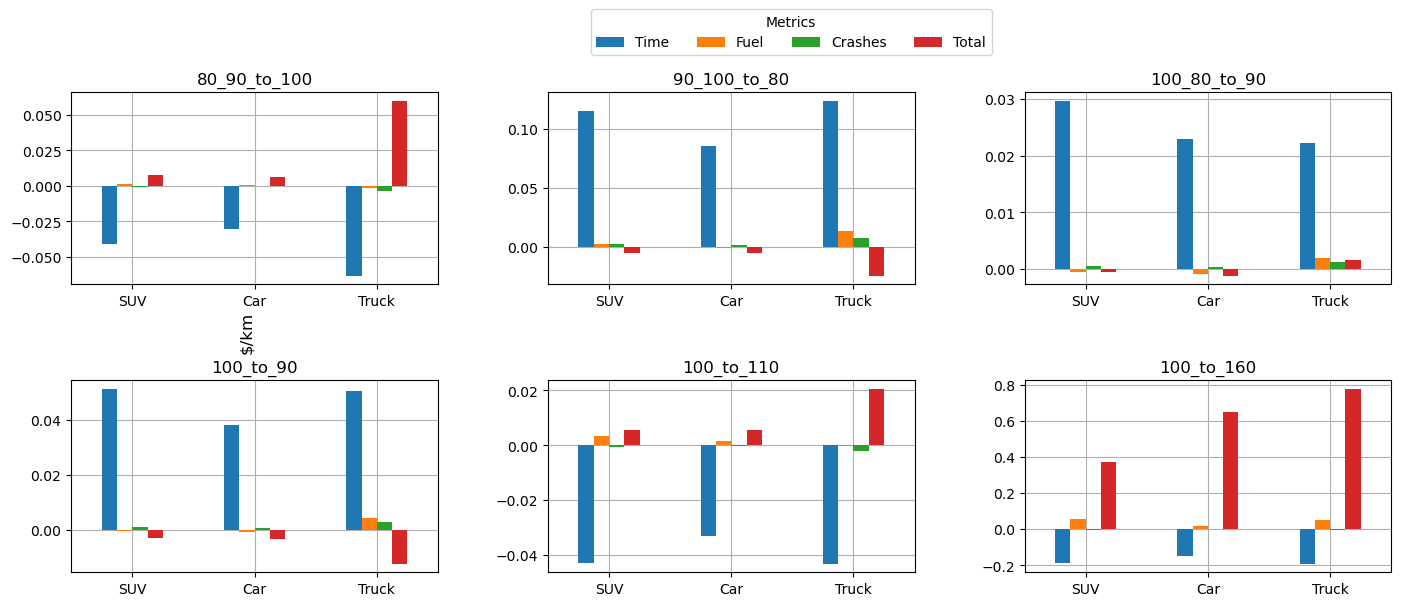

In [270]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd

# Assuming your dataframe is named 'costs'
scenario_names = ['80_90_to_100', '90_100_to_80', '100_80_to_90', '100_to_90', '100_to_110', '100_to_160']

# Create the figure and a custom gridspec layout
#spec = gridspec.GridSpec(nrows=2, ncols=3, figure=fig, height_ratios=[1, 1], hspace=0.4)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))  # Use subplots to generate axes
axes = axes.flatten() 

# Loop through each scenario name and create a new dataframe for each
for i, scenario in enumerate(scenario_names):
    ax = axes[i]
    # Filter rows where the scenario name is in the 'Unnamed: 0' column
    scenario_df = costs[costs['Unnamed: 0'].str.contains(scenario, na=False)]
    #print(scenario_df)
    # Select rows where 'Unnamed: 0' starts with 'Time', 'Fuel', 'Crashes', or 'Total' and ends with '_mean'
    filtered_df = scenario_df[
        scenario_df['Unnamed: 0'].str.startswith(('Time', 'Fuel', 'Crashes', 'Total')) & 
        scenario_df['Unnamed: 0'].str.endswith('_mean')]
    print(filtered_df)
    # Extract the relevant columns for plotting
    plot_df = filtered_df[['Unnamed: 0', 'SUV', 'Car', 'Truck']]

    order = ['Time', 'Fuel', 'DiffCrashes', 'Total']

    # Create a sorting key based on the desired order
    plot_df['sort_key'] = plot_df['Unnamed: 0'].apply(lambda x: next((i for i, word in enumerate(order) if x.startswith(word)), float('inf')))
    
    # Sort the DataFrame by the sorting key and drop the key afterward
    plot_df = plot_df.sort_values('sort_key').drop(columns='sort_key').reset_index(drop=True)
    plot_df = plot_df.set_index('Unnamed: 0')

    # Create a bar chart for the current scenario
    ax = plot_df.T.plot(kind='bar', width=0.5, ax=axes[i], zorder=2, legend=False)
    
    # Set the title and labels
    ax.set_title(f'{scenario}')
    ax.set_xticks(range(3))
    ax.set_xticklabels(['SUV', 'Car', 'Truck'], rotation=0)
    ax.grid(True, zorder=1)

# Set the shared y-label and legend
fig.text(0.04, 0.5, '$/km', va='center', rotation='vertical', fontsize='large')
fig.legend(['Time', 'Fuel', 'Crashes', 'Total'], title='Metrics', loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.05))

# Adjust layout to avoid overlap
plt.subplots_adjust(left=-0.1, right=1, top=0.9, bottom=0.1, wspace=0.3, hspace=0.5)

# Save and show the combined plot
#plt.savefig(f'Combined_graph_of_cost_per_km_5_figures.png')
plt.show()

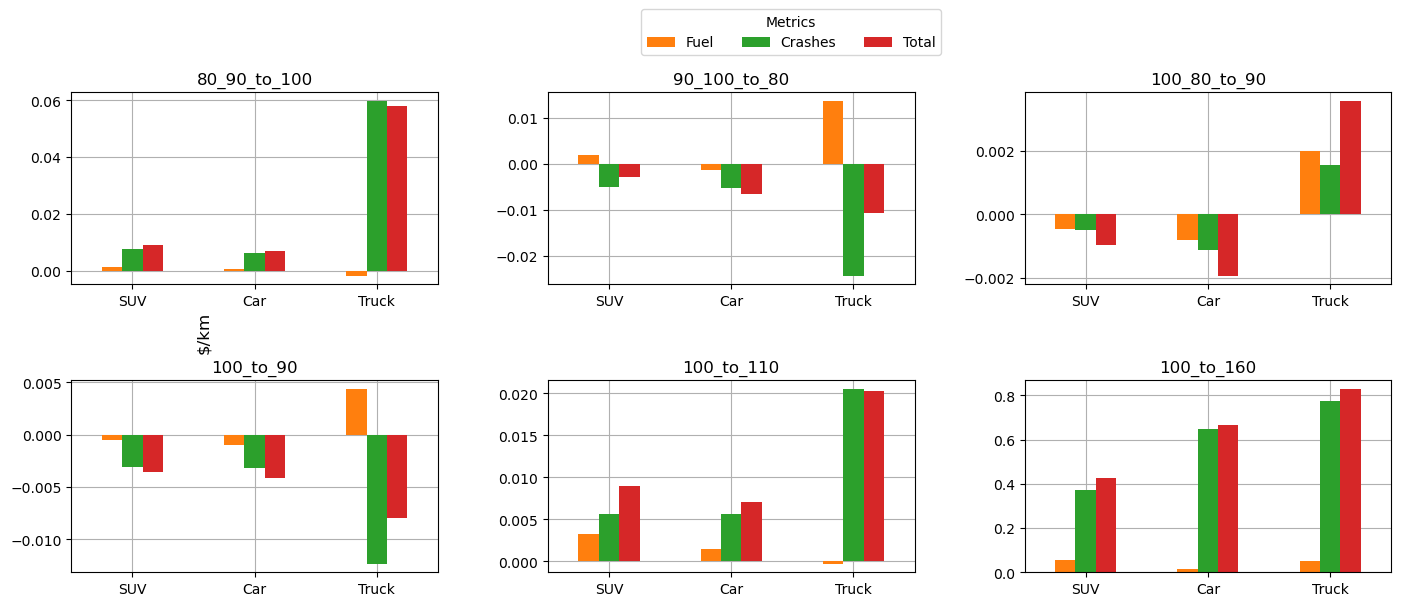

In [272]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming your dataframe is named 'costs'
scenario_names = ['80_90_to_100', '90_100_to_80', '100_80_to_90', '100_to_90', '100_to_110', '100_to_160']

# Create the figure and subplots
# Create the figure and a custom gridspec layout
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))  # Use subplots to generate axes
axes = axes.flatten() 

# Loop through each scenario name and create a new dataframe for each
for i, scenario in enumerate(scenario_names):
    # Filter rows where the scenario name is in the 'Unnamed: 0' column
    scenario_df = costs[costs['Unnamed: 0'].str.contains(scenario, na=False)]
    
    # Select rows where 'Unnamed: 0' starts with 'Fuel' or 'Crashes' and ends with '_mean'
    filtered_df = scenario_df[
        scenario_df['Unnamed: 0'].str.startswith(('Fuel', 'Crashes')) & 
        scenario_df['Unnamed: 0'].str.endswith('_mean')
    ]
    
    # Pivot the DataFrame to get the data in a plottable format
    plot_df = filtered_df[['Unnamed: 0', 'SUV', 'Car', 'Truck']].set_index('Unnamed: 0')
    
    sum_row = plot_df.sum(axis=0).to_frame().T  # Sum along rows (column-wise)
    sum_row.name = 'Total'  # Optional: Give the new row a label
    plot_df = pd.concat([plot_df,sum_row])

    # Calculate the "Total" as the sum of "Fuel" and "Crashes"
     # Create a bar chart for the current scenario
    ax = plot_df.T.plot(kind='bar', width=0.5, ax=axes[i],color=['tab:orange','tab:green','tab:red'], zorder=2, legend=False)
    
    # Plot the data for the current scenari
        # Set the title and labels
    ax.set_title(f'{scenario}')
    #axes[i].set_xlabel('Category')
    ax.set_xticks(range(3))
    ax.set_xticklabels(['SUV', 'Car', 'Truck'], rotation=0)
    ax.grid(True, zorder=1)

# Set the shared y-label and legend
fig.text(0.04, 0.5, '$/km', va='center', rotation='vertical', fontsize='large', position=(0.004, 0.5))
fig.legend(['Fuel', 'Crashes', 'Total'], title='Metrics', loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.05))

# Adjust layout to avoid overlap
plt.subplots_adjust(left=-0.1, right=1, top=0.9, bottom=0.1, wspace=0.3, hspace=0.5)
#fig.savefig(f'Combined_graph_No_Time_of_cost_per_km_160.png')
# Show the combined plot
plt.show()

In [252]:
#almost2 = pd.read_csv(f"Cost_per_FuelUp_All_Vehicles_All_Models_160.csv")
#print(almost2)

almost2['kms/day'] = almost2['DistanceTravelled'] / almost2['Days']
#print(almost2['kms/day'])
for unique in almost2['VehicleName'].unique():
    Unique = almost2[almost2['VehicleName']==unique].copy()
    mean = Unique['kms/day'].mean()
    std = Unique['kms/day'].std()
    #print(f"Vehicle {unique} travelled {mean:.2f}±{std:.2f}km/day")

for unique in almost2['VehicleClass'].unique():
    Unique = almost2[almost2['VehicleClass']==unique].copy()
    mean = Unique['kms/day'].mean()
    std = Unique['kms/day'].std()
    #print(f"Vehicle Class {unique} travelled {mean:.2f}±{std:.2f}km/day")

#almost1 = pd.read_csv(f"Vehicle_stats_all_6_scenarios_per_km_160.csv")
almost1 = almost1[['Unnamed: 0', 'SUV', 'Car', 'Truck']]
#print(almost1)
scenario_names = ['80_90_to_100', '90_100_to_80', '100_80_to_90', '100_to_90', '100_to_110', '100_to_160']
filtered_dfs = []

for scenario in scenario_names:
    almost2 = almost1[almost1['Unnamed: 0'].str.contains(scenario, na=False)]
    # Filter rows where 'Unnamed: 0' ends with '_mean' and starts with one of the desired prefixes
    filtered_df = almost2[
        almost2['Unnamed: 0'].str.endswith('_mean') & 
        almost2['Unnamed: 0'].str.startswith(('Fuel', 'Crashes', 'Time', 'Total'))
    ].copy()  # Using .copy() to avoid setting a value on a view
    
    # Add the 'Scenario' column with the current scenario
    filtered_df['Scenario'] = scenario
    
    # Add the 'Phrase' column, which extracts the prefix (Fuel, Crashes, Time, Total) from 'Unnamed: 0'
    filtered_df['Phrase'] = filtered_df['Unnamed: 0'].str.extract(r'^(Fuel|Crashes|Time|Total)')
    
    # Append the filtered DataFrame to the list
    filtered_dfs.append(filtered_df)

# Concatenate all filtered DataFrames into one
final_df = pd.concat(filtered_dfs, ignore_index=True)
final_df = final_df.drop(columns=['Unnamed: 0'])
final_df[['SUV ($/km)','Car ($/km)','Truck ($/km)']] = final_df[['SUV','Car','Truck']]
final_df = final_df[['Scenario', 'Phrase', 'SUV ($/km)', 'Car ($/km)', 'Truck ($/km)']]
# Print the resulting DataFrame
print(final_df)
#final_df.to_csv(f'combined_totals_with_time_160.csv')

        Scenario Phrase  SUV ($/km)  Car ($/km)  Truck ($/km)
0   80_90_to_100   Fuel    0.001278    0.000539     -0.001656
1   80_90_to_100   Time   -0.040962   -0.030017     -0.063145
2   90_100_to_80   Fuel    0.002014   -0.001302      0.013735
3   90_100_to_80   Time    0.114857    0.085408      0.123487
4      100_to_90   Fuel   -0.000453   -0.000817      0.002004
5      100_to_90   Time    0.029623    0.022915      0.022236
6      100_to_90   Fuel   -0.000468   -0.000939      0.004362
7      100_to_90   Time    0.051303    0.038324      0.050662
8     100_to_110   Fuel    0.003262    0.001505     -0.000258
9     100_to_110   Time   -0.043053   -0.033022     -0.043205
10    100_to_160   Fuel    0.057186    0.016391      0.050585
11    100_to_160   Time   -0.185432   -0.148534     -0.190395


In [254]:
import pandas as pd

# Fleet composition
num_suvs = 18
num_cars = 2
num_trucks = 1

#Car dominated fleet 
#num_suvs = 2
#num_cars = 18
#num_trucks = 1

# Average daily distances and their bounds
avg_suv_dist_per_day = 73.7
avg_suv_dist_per_day_lower = 43.3

avg_truck_dist_per_day = 30.1
avg_truck_dist_per_day_lower = 26.2

avg_car_dist_per_day = 75.8
avg_car_dist_per_day_lower = 36.7

# Read cost data
cost_per_km = pd.read_csv('combined_totals_with_time_160.csv')
print(cost_per_km)

# Calculate daily costs for each vehicle type (assuming there's a column 'cost_per_km' in the dataframe)
cost_per_km['Cost_per_day_suv'] = cost_per_km['SUV ($/km)'] * avg_suv_dist_per_day * num_suvs
cost_per_km['Cost_per_day_car'] = cost_per_km['Car ($/km)'] * avg_car_dist_per_day * num_cars
cost_per_km['Cost_per_day_truck'] = cost_per_km['Truck ($/km)'] * avg_truck_dist_per_day * num_trucks
cost_per_km['Cost_per_day_fleet'] = cost_per_km['Cost_per_day_suv']+cost_per_km['Cost_per_day_car']+cost_per_km['Cost_per_day_truck']
cost_per_km['Fleet_daily_distance'] = avg_suv_dist_per_day * num_suvs + avg_truck_dist_per_day * num_trucks + avg_car_dist_per_day * num_cars

# Calculate daily costs based on lower bounds
cost_per_km['Cost_per_day_suv_std'] = cost_per_km['SUV ($/km)'] * avg_suv_dist_per_day_lower * num_suvs
cost_per_km['Cost_per_day_car_std'] = cost_per_km['Car ($/km)'] * avg_car_dist_per_day_lower * num_cars
cost_per_km['Cost_per_day_truck_std'] = cost_per_km['Truck ($/km)'] * avg_truck_dist_per_day_lower * num_trucks
cost_per_km['Cost_per_day_fleet_std'] = cost_per_km['Cost_per_day_suv_std']+cost_per_km['Cost_per_day_car_std']+cost_per_km['Cost_per_day_truck_std']

days_per_year = 365.25
cost_per_km['Cost_per_year_fleet'] = cost_per_km['Cost_per_day_fleet'] * days_per_year
cost_per_km['Cost_per_year_fleet_std'] = cost_per_km['Cost_per_day_fleet_std'] * days_per_year
cost_per_km['Fleet_yearly_distance'] = cost_per_km['Fleet_daily_distance']*days_per_year

print(cost_per_km)
#cost_per_km.to_csv(f'combined_totals_with_time_160_all_cars_fleet.csv')

    Unnamed: 0      Scenario Phrase  SUV ($/km)  Car ($/km)  Truck ($/km)
0            0  80_90_to_100   Fuel    0.001278    0.000539     -0.001656
1            1  80_90_to_100   Time   -0.040962   -0.030017     -0.063145
2            2  80_90_to_100  Total   -0.033245   -0.024482     -0.026445
3            3  90_100_to_80   Fuel    0.002014   -0.001302      0.013735
4            4  90_100_to_80   Time    0.114857    0.085408      0.123487
5            5  90_100_to_80  Total    0.112224    0.079064      0.108013
6            6     100_to_90   Fuel   -0.000453   -0.000817      0.002004
7            7     100_to_90   Time    0.029623    0.022915      0.022236
8            8     100_to_90   Fuel   -0.000468   -0.000939      0.004362
9            9     100_to_90   Time    0.051303    0.038324      0.050662
10          10     100_to_90  Total    0.028675    0.020920      0.020285
11          11     100_to_90  Total    0.047039    0.032071      0.029961
12          12    100_to_110   Fuel   

In [256]:
cost_per_km['Litre_change_per_year_fleet'] = np.nan
cost_per_km['Hour_change_per_year_fleet'] = np.nan
# Apply the calculation conditionally for rows where Phrase is 'Fuel'
cost_per_km.loc[cost_per_km['Phrase'] == 'Fuel', 'Litre_change_per_year_fleet'] = (cost_per_km['Cost_per_year_fleet'] / 2.189)
cost_per_km.loc[cost_per_km['Phrase'] == 'Time', 'Hour_change_per_year_fleet'] = (cost_per_km['Cost_per_year_fleet'] / 150)
cost_per_km.loc[cost_per_km['Phrase'] == 'Fuel', 'CO2_emission_change_per_year_fleet'] = (2.68*cost_per_km['Litre_change_per_year_fleet'])
print(cost_per_km)
#cost_per_km.to_csv(f'combined_totals_with_time_160_all_cars_fleet.csv')

    Unnamed: 0      Scenario Phrase  SUV ($/km)  Car ($/km)  Truck ($/km)  \
0            0  80_90_to_100   Fuel    0.001278    0.000539     -0.001656   
1            1  80_90_to_100   Time   -0.040962   -0.030017     -0.063145   
2            2  80_90_to_100  Total   -0.033245   -0.024482     -0.026445   
3            3  90_100_to_80   Fuel    0.002014   -0.001302      0.013735   
4            4  90_100_to_80   Time    0.114857    0.085408      0.123487   
5            5  90_100_to_80  Total    0.112224    0.079064      0.108013   
6            6     100_to_90   Fuel   -0.000453   -0.000817      0.002004   
7            7     100_to_90   Time    0.029623    0.022915      0.022236   
8            8     100_to_90   Fuel   -0.000468   -0.000939      0.004362   
9            9     100_to_90   Time    0.051303    0.038324      0.050662   
10          10     100_to_90  Total    0.028675    0.020920      0.020285   
11          11     100_to_90  Total    0.047039    0.032071      0.029961   

# Find percentage difference of fuel and time in each model

In [ ]:
#df = pd.read_csv(f'AAA_All_Vehicles_All_Model_160.csv')
df['TrueFuel'] = df['FuelModel']
df.drop(columns=['FuelModel'])
print(df.columns)

In [ ]:
time_sums = df.filter(like='Time').sum()
print("Time Sums:")
print(time_sums)

# Summing up 'Fuel' columns
fuel_sums = df.filter(like='Fuel').sum()
print("\nFuel Sums:")
print(fuel_sums)

In [ ]:
time_sums = df.filter(like='Time').sum()
time_percentage_diff = ((time_sums - time_sums['TrueTime']) / time_sums['TrueTime']) * 100

# Summing up 'Fuel' columns and computing percentage difference relative to 'TrueFuel'
fuel_sums = df.filter(like='Fuel').sum()
fuel_percentage_diff = ((fuel_sums - fuel_sums['TrueFuel']) / fuel_sums['TrueFuel']) * 100

# Printing results
print("Time Percentage Differences:")
print(time_percentage_diff)

print("\nFuel Percentage Differences:")
print(fuel_percentage_diff)